<a href="https://colab.research.google.com/github/othmane42/defi1_hackAI/blob/main/D%C3%A9fis2_submission_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!python -m pip install -q transformers  datasets  sentencepiece

     |████████████████████████████████| 5.8 MB 34.8 MB/s 
     |████████████████████████████████| 452 kB 72.7 MB/s 
     |████████████████████████████████| 1.3 MB 59.9 MB/s 
     |████████████████████████████████| 7.6 MB 54.8 MB/s 
     |████████████████████████████████| 182 kB 75.3 MB/s 
     |████████████████████████████████| 213 kB 58.8 MB/s 
     |████████████████████████████████| 132 kB 73.2 MB/s 
     |████████████████████████████████| 127 kB 71.9 MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 0.6. Importation de librairies utiles

In [24]:
import os
import numpy as np
import pandas as pd
from transformers import TrainingArguments, Trainer
from transformers import CamembertForSequenceClassification, CamembertTokenizer
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score

np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan', precision=3, suppress=False, threshold=1000, formatter=None)

# 1. Chargement de la base de données

## 1.1. Chargement pour sklearn

Le bout de code suivant montre comment charger le dataset du challenge pour sklearn. Le corpus se trouve donc dans la variable *ds_train['data']* et les labels dans *ds_train['label']*.

In [7]:
ROOTDIR = "/content/drive/MyDrive/MyDataset/Defi2Dataset"

In [8]:
ds_train = pd.read_csv(os.path.join(ROOTDIR,'fake_train.csv') )
ds_test = pd.read_csv(os.path.join(ROOTDIR,'fake_test.csv'))

print("Nombre de news")
print(len(ds_train))
print("")
print("Affichage de la 1ère news")
print(ds_train['data'][0])
print("")
print("Label de la 1ère news")
print(ds_train['label'][0])

Nombre de news
1458

Affichage de la 1ère news
Au 22e jour consécutif de la grève reconductible contre la réforme des retraites (soit autant de jours que le long conflit de 1995), le taux de grévistes à la SNCF a légèrement baissé à 9,6 % jeudi matin, contre 9,8 % mardi, selon la direction du groupe public. Parmi les personnels indispensables à la circulation des trains, moins de la moitié des conducteurs (42,1 %) et le quart (24 %) des contrôleurs étaient grévistes, des taux en recul par rapport à mardi (49,3 % chez les conducteurs), jour du réveillon de Noël et précédent jour de publication de ces taux. Le taux des aiguilleurs en grève a légèrement augmenté, à 13,8 %.

Label de la 1ère news
0


In [9]:
ds_train.rename(columns={"label":"labels"},inplace=True)
ds_test.rename(columns={"label":"labels"},inplace=True)
ds_train.drop(columns=["Unnamed: 0"],inplace=True)
ds_test.drop(columns=["Unnamed: 0"],inplace=True)



In [ ]:
ds_train.target_name.unique()

array(['News', 'Fake News'], dtype=object)

In [ ]:
ds_train.head()

,data,labels,target_name
0,Au 22e jour consécutif de la grève reconductib...,0,News
1,"Depuis plusieurs mois, les initiatives des che...",0,News
2,Google vient d'introduire une mise à jour de...,0,News
3,Portrait. Chacun s’empresse autour d’elle tan...,0,News
4,« Il n’y a pas de risque de pénurie » de carbu...,0,News


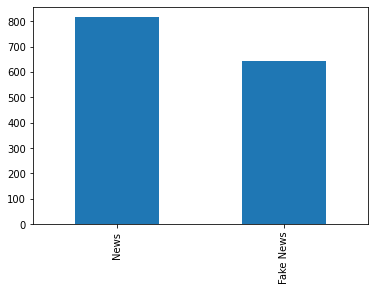

In [11]:
ds_train.target_name.value_counts().plot(kind="bar")

In [12]:
ds_train.to_csv("fake_train_.csv",index=False)
ds_test.to_csv("fake_test_.csv",index=False)

# 1.2. Pipeline 1(first approach ) Chargement pour les transformers de Huggingface

mddel used:Camembert

In [46]:
dataset_train = load_dataset("csv", data_files="fake_train_.csv", split='train')
dataset_test = load_dataset("csv", data_files="fake_test_.csv")

print("Nombre de news")
print(len(dataset_train))
print("")
print("Affichage de la 1ère news")
print(dataset_train[0])
print("")
print("Contenu de la 1ère news")
print(dataset_train[0]['data'])
print("")
print("Label de la 1ère news")
print("{} => {}".format(dataset_train[0]['labels'], dataset_train[0]['target_name']))
print("")

print("Affichage de la dernière news")
print(dataset_train[-1])
print("")
print("Contenu de la dernière news")
print(dataset_train[-1]['data'])
print("")
print("Label de la dernière news")
print("{} => {}".format(dataset_train[-1]['labels'], dataset_train[-1]['target_name']))

  0%|          | 0/1 [00:00<?, ?it/s]

Nombre de news
1458

Affichage de la 1ère news
{'data': 'Au 22e jour consécutif de la grève reconductible contre la réforme des retraites (soit autant de jours que le long conflit de 1995), le taux de grévistes à la SNCF a légèrement baissé à 9,6 % jeudi matin, contre 9,8 % mardi, selon la direction du groupe public. Parmi les personnels indispensables à la circulation des trains, moins de la moitié des conducteurs (42,1 %) et le quart (24 %) des contrôleurs étaient grévistes, des taux en recul par rapport à mardi (49,3 % chez les conducteurs), jour du réveillon de Noël et précédent jour de publication de ces taux. Le taux des aiguilleurs en grève a légèrement augmenté, à 13,8 %.', 'labels': 0, 'target_name': 'News'}

Contenu de la 1ère news
Au 22e jour consécutif de la grève reconductible contre la réforme des retraites (soit autant de jours que le long conflit de 1995), le taux de grévistes à la SNCF a légèrement baissé à 9,6 % jeudi matin, contre 9,8 % mardi, selon la direction du g

In [44]:
dataset_test

DatasetDict({
    train: Dataset({
        features: ['data', 'labels', 'target_name'],
        num_rows: 486
    })
})

In [14]:
train_val_dataset=dataset_train.train_test_split(test_size=0.2,seed=42)

In [47]:
# You can replace "camembert-base" with any other model from the table, e.g. "camembert/camembert-large".
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
camembert = CamembertForSequenceClassification.from_pretrained(
    'camembert-base',
    num_labels = 2)


def preprocess_function(examples):
    return tokenizer(examples['data'], truncation=True)

tokenized_hugging_train = train_val_dataset["train"].map(preprocess_function, batched=True,batch_size=8)
tokenized_hugging_val = train_val_dataset["test"].map(preprocess_function, batched=True,batch_size=8)
tokenized_hugging_test = dataset_test["train"].map(preprocess_function, batched=True,batch_size=8)


loading file sentencepiece.bpe.model from cache at /root/.cache/huggingface/hub/models--camembert-base/snapshots/3f452b6e5a89b0e6c828c9bba2642bc577086eae/sentencepiece.bpe.model
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--camembert-base/snapshots/3f452b6e5a89b0e6c828c9bba2642bc577086eae/config.json
Model config CamembertConfig {
  "_name_or_path": "camembert-base",
  "architectures": [
    "CamembertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "camembert",
  "num_attention_heads": 12,
  "num_hi

In [48]:
categories = ['News', 'Fake News']
def map_label(sample):
  ind = categories.index(sample['target_name'])
  sample['labels'] = ind
  return sample

tokenized_hugging_train = tokenized_hugging_train.map(map_label, batched=False)
tokenized_hugging_test = tokenized_hugging_test.map(map_label, batched=False)
tokenized_hugging_val = tokenized_hugging_val.map(map_label, batched=False)


In [33]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(-1)
    f1 = f1_score(labels, predictions)
    return {'f1': f1}


In [34]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_args = TrainingArguments(
    output_dir="./content/drive/MyDrive/MyModels/results_camamembert",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    metric_for_best_model="f1",
    save_strategy="epoch", # on enregistre le modèle à chaque epoch
    evaluation_strategy="epoch", # on évalue le modèle à chaque epoch
    load_best_model_at_end=True # on charge le meilleur modèle (en terme d'accuracy) à la fin de l'entrainement
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [35]:
trainer = Trainer(
    model=camembert,
    args=training_args,
    train_dataset=tokenized_hugging_train,
    eval_dataset=tokenized_hugging_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [36]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `CamembertForSequenceClassification.forward` and have been ignored: target_name, data. If target_name, data are not expected by `CamembertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1166
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1460
  Number of trainable parameters = 110623490


Epoch,Training Loss,Validation Loss,F1
1,No log,0.032371,0.991736
2,No log,0.026353,0.991667
3,No log,0.085517,0.983193
4,0.056300,0.040063,0.991667
5,0.056300,0.047586,0.991667
6,0.056300,0.050955,0.991667
7,0.000700,0.052489,0.991667
8,0.000700,0.053965,0.991667
9,0.000700,0.054888,0.991667
10,0.000700,0.055252,0.991667


The following columns in the evaluation set don't have a corresponding argument in `CamembertForSequenceClassification.forward` and have been ignored: target_name, data. If target_name, data are not expected by `CamembertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 8
Saving model checkpoint to ./content/drive/MyDrive/MyModels/results_camamembert/checkpoint-146
Configuration saved in ./content/drive/MyDrive/MyModels/results_camamembert/checkpoint-146/config.json
Model weights saved in ./content/drive/MyDrive/MyModels/results_camamembert/checkpoint-146/pytorch_model.bin
tokenizer config file saved in ./content/drive/MyDrive/MyModels/results_camamembert/checkpoint-146/tokenizer_config.json
Special tokens file saved in ./content/drive/MyDrive/MyModels/results_camamembert/checkpoint-146/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `Came

TrainOutput(global_step=1460, training_loss=0.019645144157621957, metrics={'train_runtime': 1235.5983, 'train_samples_per_second': 9.437, 'train_steps_per_second': 1.182, 'total_flos': 3061728795688800.0, 'train_loss': 0.019645144157621957, 'epoch': 10.0})

In [50]:
trainer.evaluate(eval_dataset=tokenized_hugging_test)

The following columns in the evaluation set don't have a corresponding argument in `CamembertForSequenceClassification.forward` and have been ignored: target_name, data. If target_name, data are not expected by `CamembertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 486
  Batch size = 8


{'eval_loss': 0.11775372177362442,
 'eval_f1': 0.9739952718676123,
 'eval_runtime': 13.0473,
 'eval_samples_per_second': 37.249,
 'eval_steps_per_second': 4.675,
 'epoch': 10.0}

# pipeline 2 (second approach )  ML model with tf-idf tokenizers 

model used ( comparision using pycaret)